In [16]:
import os
from datetime import datetime
#from datetime import date
import pymysql
from sqlalchemy import create_engine
from decouple import config 
from dotenv import load_dotenv
import pandas as pd
from numpy import int16
from enum import Enum

In [17]:
# Using enum class create enumerations
class Constante(Enum):
   march_1_2021 = "2021-03-01"
   specific = "2021-09-06"

In [18]:
load_dotenv()
# get the environment variables needed
USER= config('USRCaris')
PASSWORD= config('PASSCaris')
HOSTNAME= config('HOSTCaris')
DBNAME= config('DBCaris')

# get the engine to connect and fetch
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")
query = f'''
    SELECT 
    agent_username, COUNT(*) AS nbre,
    dsd.organisation,
    dsd.timeEnd as entry_date
FROM
    caris_db.dreams_surveys_data dsd
WHERE
    dsd.timeEnd >= '{Constante.specific.value}'
GROUP BY agent_username
'''

agent = pd.read_sql_query(query,engine,parse_dates=True)
# get the test excel file from Query

# close the pool of connection
engine.dispose()

## Agent DREAMS sortant du Systeme

In [19]:
agent.rename(columns={'agent_username':'username'},inplace=True)
agent

,username,nbre,organisation,entry_date
0,2davy,16,CARIS,2021-09-06 19:36:29
1,2diegoarmando,5,CARIS,2021-09-06 15:28:13
2,2eliona,15,CARIS,2021-09-06 19:12:16
3,2ernst,23,CARIS,2021-09-08 07:54:39
4,2gerald,43,CARIS,2021-09-07 14:56:34
5,2roselord,21,CARIS,2021-09-07 14:34:33
6,2wilnes,12,CARIS,2021-09-09 18:25:03
7,2woodridchard,46,CARIS,2021-09-07 15:11:17
8,6celimene,2,CARIS,2021-09-08 15:25:52
9,6gerana,24,CARIS,2021-09-07 16:18:41


In [20]:
agent_name = pd.read_excel("caris-test_users_7453177b42914ad2978e3c465e39dab1.xlsx")

In [21]:
agent_name = agent_name[["username","name"]]

## Liste de tous les agents avec Leur nom

In [22]:
agent_name

,username,name
0,1aldonzar,elcie aldonzar
1,1alexandra,Alexandra Joseph
2,1annuelle,Annuelle Eustache
3,1claudius,Claudius Gladys
4,1coldina,Coldina Duverny
...,...,...
742,s2julnor,Julnor Beaubrun
743,s2mirlene,Vernet Mirlene
744,stfleur,Jesula St Fleur
745,sylvietest,sylvie rousseau


## MERGE (Vlookup)

In [23]:
performanceAgents = agent_name.merge(agent,on="username",how="inner")

In [24]:
performanceAgents

,username,name,nbre,organisation,entry_date
0,2davy,Jean Davy Mexil,16,CARIS,2021-09-06 19:36:29
1,2diegoarmando,Diego Armando Dorlean,5,CARIS,2021-09-06 15:28:13
2,2eliona,Eliona Fredly,15,CARIS,2021-09-06 19:12:16
3,2ernst,Ernst Belabre,23,CARIS,2021-09-08 07:54:39
4,2gerald,Gerald Poteau,43,CARIS,2021-09-07 14:56:34
5,2roselord,Rose-Lord Despeignes,21,CARIS,2021-09-07 14:34:33
6,2wilnes,Gerant Louis Wilnes,12,CARIS,2021-09-09 18:25:03
7,2woodridchard,Wood-Ridchard Bon,46,CARIS,2021-09-07 15:11:17
8,6celimene,Celimene Laine,2,CARIS,2021-09-08 15:25:52
9,6gerana,Gerana David,24,CARIS,2021-09-07 16:18:41


In [25]:
performanceAgents.nbre.sum()

218

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [27]:
from datetime import datetime
date_du_jour = datetime.today().strftime("%d_%m_%Y")

In [28]:
orderdata = performanceAgents.nbre.sort_values().to_list()

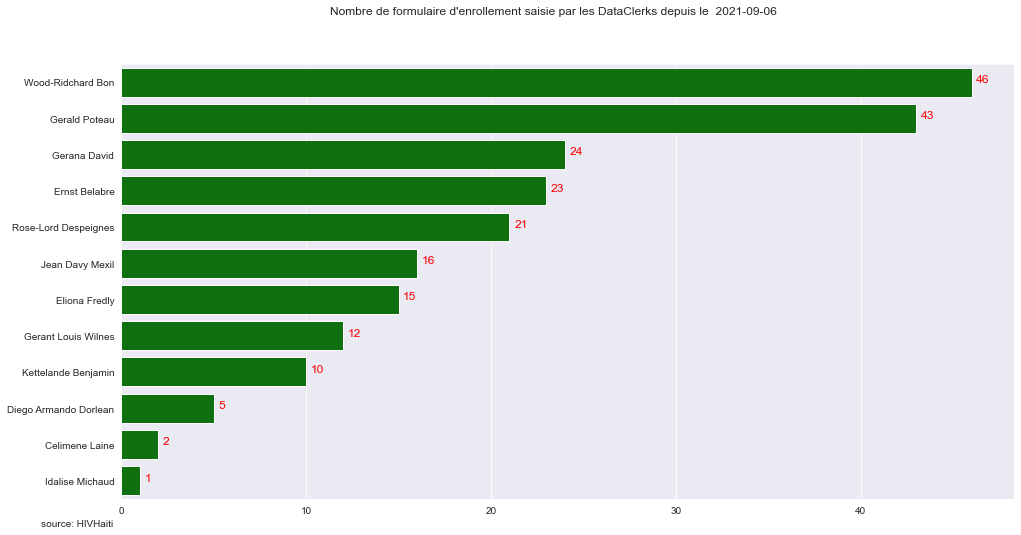

In [29]:
plt.figure(figsize=(16,8))
#plt.subplots(figsize=(16,8))
sns.set_style("darkgrid")
splot = sns.barplot(x="nbre",y="name",data=performanceAgents,color="Green",order=performanceAgents.sort_values("nbre",ascending=False).name,ci=False)
splot.set_xlabel("")
splot.set_ylabel("")
plt.suptitle(f"Nombre de formulaire d'enrollement saisie par les DataClerks depuis le  {Constante.specific.value}")
for p in splot.patches:
    width = p.get_width()
    plt.text(0.25+p.get_width(), p.get_y()+0.50*p.get_height(),
             '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))

plt.annotate(
    "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
             xycoords='axes fraction', textcoords='offset points', va='top'
)

plt.savefig(f"saisie_screening_{date_du_jour}",dpi=1000)

In [30]:
performanceAgents.to_excel(f"performance_formulaire_denrolement_{date_du_jour}.xlsx",index=False,na_rep="NULL")
#performanceAgents.to_excel(f"performance_formulaire_denrolement_depuis_1Mars2021.xlsx",index=False,na_rep="NULL")